# Question 3: How does the number of tools planned to be used in future correlate with number of tools used,the stance for AI, work experience and the job satisfaction?

In [1]:
# List all imported modules and functions / classes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,  OrdinalEncoder
from my_functions import filter_columns_from_data_source


## Gather data
For the question how the number of tools used correlated with number of tools used,the stance for AI, work experience and the job satisfaction the following columns have been selected:
* stance for AI: AISent
* number of tools used to be calculated from: AISearchDevHaveWorkedWith
* work experience: WorkExp
* job satisfaction: JobSat

The target value, number of tools to use in future is taken from the column AISearchDevWantToWorkWith
Define selected columns and read the from the original data.
Read data set from source: https://survey.stackoverflow.co/datasets/stack-overflow-developer-survey-2024.zip

In [2]:
selected_columns=[ 
    "AISent",
    "AISearchDevHaveWorkedWith", # list of tool selection
    "AISearchDevWantToWorkWith", # list of tool selection
    "WorkExp",
    "JobSat"
]

df_filtered=filter_columns_from_data_source(selected_columns,"survey_results_public.csv")
df_filtered.info()
df_filtered.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65437 entries, 0 to 65436
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AISent                     45873 non-null  object 
 1   AISearchDevHaveWorkedWith  44453 non-null  object 
 2   AISearchDevWantToWorkWith  36701 non-null  object 
 3   WorkExp                    29658 non-null  float64
 4   JobSat                     29126 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


,WorkExp,JobSat
count,29658.000000,29126.000000
mean,11.466957,6.935041
std,9.168709,2.088259
min,0.000000,0.000000
25%,4.000000,6.000000
50%,9.000000,7.000000
75%,16.000000,8.000000
max,50.000000,10.000000


## Clean the data
Make sure that while cleaning the stance for AI contains all options 

In [3]:
print(df_filtered["AISent"].unique())

['Very favorable' nan 'Favorable' 'Indifferent' 'Unsure'
 'Very unfavorable' 'Unfavorable']


Since nan in the columns tools used and tools planned to be used can be transformed into the count 0, the calculation of tools used and planned to be used is done before removeng remaining nans. Subsequently the columns 
* AISearchDevHaveWorkedWith
* AISearchDevWantToWorkWith

will be removed

In [4]:
df_filtered["NoOfAIToolsWorkedWith"]=df_filtered["AISearchDevHaveWorkedWith"].apply(lambda item : len(item.split(";")) if isinstance(item, str) else 0)
df_filtered["NoOfAIToolsWantToWorkWith"]=df_filtered["AISearchDevWantToWorkWith"].apply(lambda item : len(item.split(";")) if isinstance(item, str) else 0)

df_filtered=df_filtered.drop(["AISearchDevHaveWorkedWith","AISearchDevWantToWorkWith"],axis=1)




Now remove all rows that contain at least one column with a nan value and check that the stance for AI is still containing all selections options from the 2024 Developer Survey.pdf

In [5]:
# remove nan
df_clean=df_filtered.dropna(how="any")

# check all attitudes towards AI contained
print(df_clean["NoOfAIToolsWantToWorkWith"].unique())
df_clean.info()


[ 3  2  1  4  0  5  9  7 14  6  8 25 11 10 17 24 18 13 23 12 19 16]
<class 'pandas.core.frame.DataFrame'>
Index: 22199 entries, 10 to 65265
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AISent                     22199 non-null  object 
 1   WorkExp                    22199 non-null  float64
 2   JobSat                     22199 non-null  float64
 3   NoOfAIToolsWorkedWith      22199 non-null  int64  
 4   NoOfAIToolsWantToWorkWith  22199 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 1.0+ MB


Now transform the stance for AI into an ordinal value using ordinal encoder to enable a linear regression model

In [6]:
ordinal_encoder=OrdinalEncoder()

df_clean["AISent"]=ordinal_encoder.fit_transform(df_clean[["AISent"]])

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 22199 entries, 10 to 65265
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AISent                     22199 non-null  float64
 1   WorkExp                    22199 non-null  float64
 2   JobSat                     22199 non-null  float64
 3   NoOfAIToolsWorkedWith      22199 non-null  int64  
 4   NoOfAIToolsWantToWorkWith  22199 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 1.0 MB


/tmp/ipykernel_659/3868492740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["AISent"]=ordinal_encoder.fit_transform(df_clean[["AISent"]])


## Analyse the data
Check the historgrams of the feature selected.

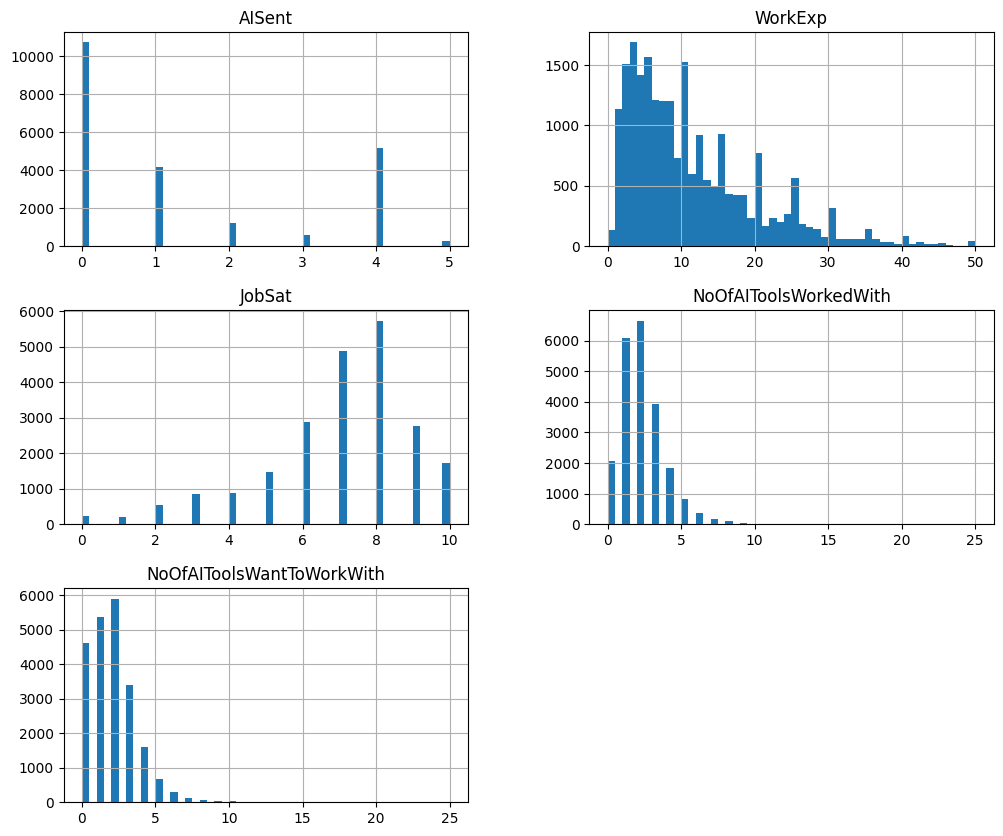

In [7]:
df_clean.hist(bins=50, figsize=(12, 10))
plt.show()


Check for correlation between the features and the target as well as among the features themselves.

In [8]:
# analyse correlations
corr_matrix=df_clean.corr()
# Print the correlation matrix sorted by linear correlation with the target
corr_matrix["NoOfAIToolsWantToWorkWith"].sort_values(ascending=False)



NoOfAIToolsWantToWorkWith    1.000000
NoOfAIToolsWorkedWith        0.593363
AISent                       0.056129
JobSat                       0.018485
WorkExp                     -0.031167
Name: NoOfAIToolsWantToWorkWith, dtype: float64

There is a very weak correlation between the number of AI tools the developers have worked with and the number of AI tools they want to work with. All other features show no correlation. Visualize this using a heatmap.


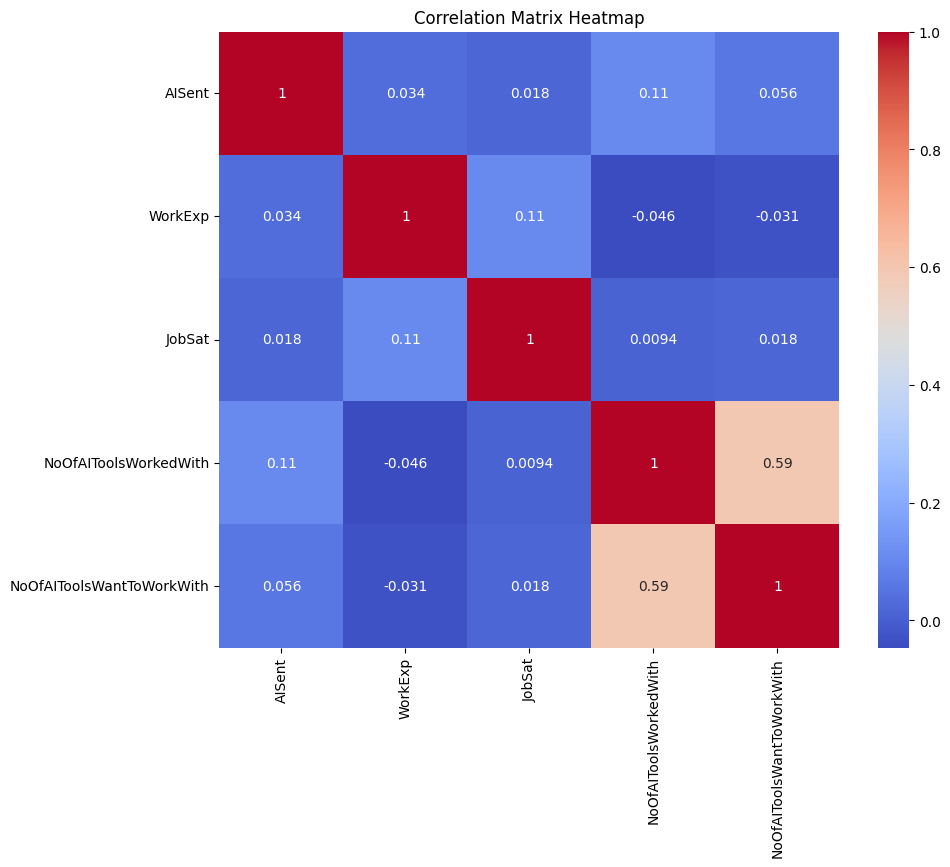

In [9]:
# plot heat map for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

## model data
Despite the lack of correlation with all selected features, a first model is developed taking all features into account.
### All feature model
* First step: separate the target column from the feature columns and then create the test and training set with an 80%-20% split. 
* Second step: train linear regression model
* Third step: evaluate the 

In [10]:
y=df_clean["NoOfAIToolsWantToWorkWith"]
X=df_clean.drop(["NoOfAIToolsWantToWorkWith"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()


,AISent,WorkExp,JobSat,NoOfAIToolsWorkedWith
44167,0.0,7.0,8.0,1
2769,1.0,4.0,3.0,5
39377,4.0,10.0,10.0,3
45688,0.0,7.0,8.0,3
40456,4.0,25.0,5.0,4


In [11]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

Run the predictions for this linear regression model and calculate the R2 and the MSE value for the test and the train data.

In [12]:
linear_predictions_train = linear_model.predict(X_train)
linear_predictions_test = linear_model.predict(X_test)

rmse_train = root_mean_squared_error(y_train, linear_predictions_train)
r2_train=r2_score(y_train,linear_predictions_train)
print("Training data:")
print(f"- R2 value for training data: {r2_train}.")
print(f"- RMSE value for training data :{rmse_train}.")
r2_test=r2_score(y_test,linear_predictions_test)
rmse_test = root_mean_squared_error(y_test, linear_predictions_test)
print("Test data:")
print(f"- R2 value for test data: {r2_test}.")
print(f"- RMSE value for test data :{rmse_test}.")


Training data:
- R2 value for training data: 0.33969832564296953.
- RMSE value for training data :1.424038541479591.
Test data:
- R2 value for test data: 0.3959436176497725.
- RMSE value for test data :1.4444653141200434.


The root mean square error is not too large but the R2 value is quite low. Therefore the idea is to reduce the number of features to just the number of AI tools already used and check the models accuracy. 
### Single feature model
For the single feature model only the column NoOfAIToolsWorkedWith is used.

In [13]:
X_train_simple=X_train[["NoOfAIToolsWorkedWith"]]
X_test_simple=X_test[["NoOfAIToolsWorkedWith"]]

X_train_simple.head()


,NoOfAIToolsWorkedWith
44167,1
2769,5
39377,3
45688,3
40456,4


In [14]:
simple_model=LinearRegression()
simple_model.fit(X_train_simple, y_train)


LinearRegression()

In [15]:
simple_predictions_train = simple_model.predict(X_train_simple)
simple_predictions_test = simple_model.predict(X_test_simple)
simple_rmse_train = root_mean_squared_error(y_train, simple_predictions_train)
simple_r2_train=r2_score(y_train,simple_predictions_train)
print("Training data:")
print(f"- R2 value for training data: {simple_r2_train}.")
print(f"- RMSE value for training data :{simple_rmse_train}.")
simple_r2_test=r2_score(y_test,simple_predictions_test)
simple_rmse_test = root_mean_squared_error(y_test, simple_predictions_test)
print("Test data:")
print(f"- R2 value for test data: {simple_r2_test}.")
print(f"- RMSE value for test data :{simple_rmse_test}.")

Training data:
- R2 value for training data: 0.3393946777595329.
- RMSE value for training data :1.4243659347041022.
Test data:
- R2 value for test data: 0.3959922962617849.
- RMSE value for test data :1.4444071109578063.


Visualize the low correlation which is seen in the R2 value for both the full featured and the single feature model. 

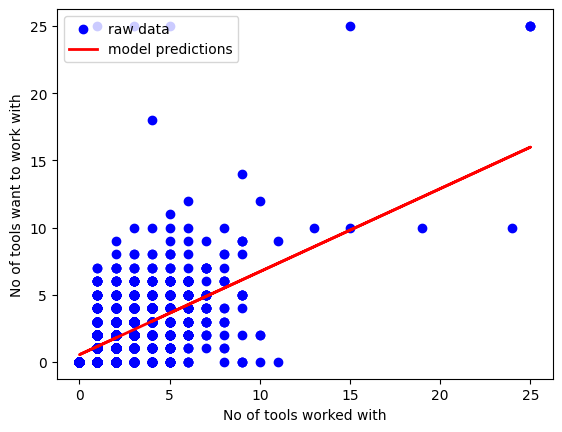

In [16]:
plt.scatter(X_test_simple, y_test, color='blue', label='raw data')
plt.plot(X_test_simple, simple_predictions_test, color='red', linewidth=2, label='model predictions')
plt.xlabel("No of tools worked with")
plt.ylabel("No of tools want to work with")
plt.legend(loc="upper left")
plt.show()

As a conclusion, the diagram clearly shows that there is no correlation between the number of tools worked with and the number of tools the developer want to work with.